# Import

In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import shutil
import itertools
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from os import listdir
from os.path import isfile, join
from PIL import Image
from pathlib import Path
from skimage.color import rgb2gray
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [ ]:
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from numpy.random import seed
seed(1305)
tf.random.set_seed(1305)

In [ ]:
def searching_all_files(directory: Path):   
    file_list = [] # A list for storing files existing in directories

    for x in directory.iterdir():
        if x.is_file():

           file_list.append(str(x))
        else:

           file_list.append(searching_all_files(directory/x))

    return file_list

In [ ]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return list(itertools.chain.from_iterable(listOfLists))

#Parameters


In [ ]:
lr = 0.0001
n_epochs = 1000
n_batch = 8

RESIZE = False
CLAHE = True
OCTA = True
DataAugmentation = True

In [ ]:
X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/X_train_augmented_partial_304.npy')
y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/y_train_augmented_partial_304.npy')
X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/X_test_augmented_partial_304.npy')
y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/y_test_augmented_partial_304.npy')
X_valid = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/X_val_augmented_partial_304.npy')
y_valid = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/y_val_augmented_partial_304.npy')

#Train, val and test

In [ ]:
'''
X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_OCTA_CLAHE.npy')
X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_OCTA_CLAHE.npy')
y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train.npy')
y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test.npy')
'''

In [ ]:
'''if CLAHE:
  if OCTA:
    if DataAugmentation:
      X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/X_train_augmented_partial_304.npy')
      y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/y_train_augmented_partial_304.npy')
      X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/X_test_augmented_partial_304.npy')
      y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/y_test_augmented_partial_304.npy')
      X_valid = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/X_val_augmented_partial_304.npy')
      y_valid = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/Augmented/y_val_augmented_partial_304.npy')
    else:
      X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_OCTA_CLAHE.npy')
      X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_OCTA_CLAHE.npy')
      y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train.npy')
      y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test.npy')

  else:  
    X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_CLAHE.npy')
    X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_CLAHE.npy')
    y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train.npy')
    y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test.npy')

else:
  X_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train.npy')
  X_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test.npy')
  y_train = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train.npy')
  y_test = np.load('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test.npy')'''

In [ ]:
X_test.shape

(20, 256, 256, 1)

In [ ]:
if DataAugmentation==False:
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.10, random_state = 42)

In [ ]:
X_train.shape

(1944, 256, 256, 1)

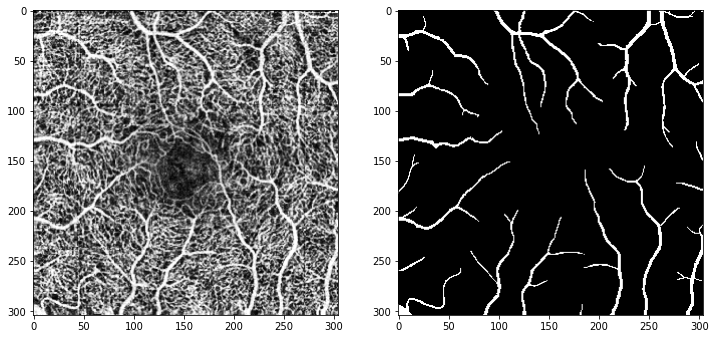

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0],cmap = 'gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0],cmap = 'gray')
plt.show()

# Architecture Autoencoder

In [ ]:
def jacard_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
  return -jacard_coef(y_true, y_pred)

In [ ]:
if RESIZE:
  input_img = keras.Input(shape=(256, 256, 1)) #dimensione dell'immagine 150X150RGB
else:
  input_img = keras.Input(shape=(304, 304, 1)) #dimensione dell'immagine 150X150RGB

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #16 filtri da 3x3 
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x) #potrebbe essere il nostro latent space

# at this point the representation is (19, 19, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.ZeroPadding2D(padding=(2, 2))(x) #capire cosa faccia (prima c'era 1 per 150)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) #qua c'è sigmoid perchè l'output di una floating point images sta sempre tra 0 e 1.

opt = keras.optimizers.Adam(learning_rate=lr)

autoencoder = keras.Model(input_img, decoded) #la passa a tutta la rete
autoencoder.compile(optimizer=opt, loss=[jacard_coef_loss], metrics=[jacard_coef]) #provare con adadelta e binary_crossentropy
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #provare con adadelta e binary_crossentropy

NameError: ignored

In [ ]:
#plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [ ]:
storico=autoencoder.fit(X_train, y_train,
                batch_size = n_batch, 
                verbose=1, 
                epochs=n_epochs,
                validation_data=(X_valid,y_valid),
                shuffle=True,)

Epoch 1/1000
18/18 [==============================] - 13s 34ms/step - loss: -0.0619 - jacard_coef: 0.0619 - val_loss: -0.0621 - val_jacard_coef: 0.0621
Epoch 2/1000
18/18 [==============================] - 0s 22ms/step - loss: -0.0621 - jacard_coef: 0.0621 - val_loss: -0.0623 - val_jacard_coef: 0.0623
Epoch 3/1000
18/18 [==============================] - 0s 23ms/step - loss: -0.0624 - jacard_coef: 0.0624 - val_loss: -0.0627 - val_jacard_coef: 0.0627
Epoch 4/1000
18/18 [==============================] - 0s 23ms/step - loss: -0.0628 - jacard_coef: 0.0628 - val_loss: -0.0633 - val_jacard_coef: 0.0633
Epoch 5/1000
18/18 [==============================] - 0s 25ms/step - loss: -0.0636 - jacard_coef: 0.0636 - val_loss: -0.0642 - val_jacard_coef: 0.0642
Epoch 6/1000
18/18 [==============================] - 0s 25ms/step - loss: -0.0647 - jacard_coef: 0.0647 - val_loss: -0.0653 - val_jacard_coef: 0.0653
Epoch 7/1000
18/18 [==============================] - 0s 22ms/step - loss: -0.0655 - jacard_c

#Losses

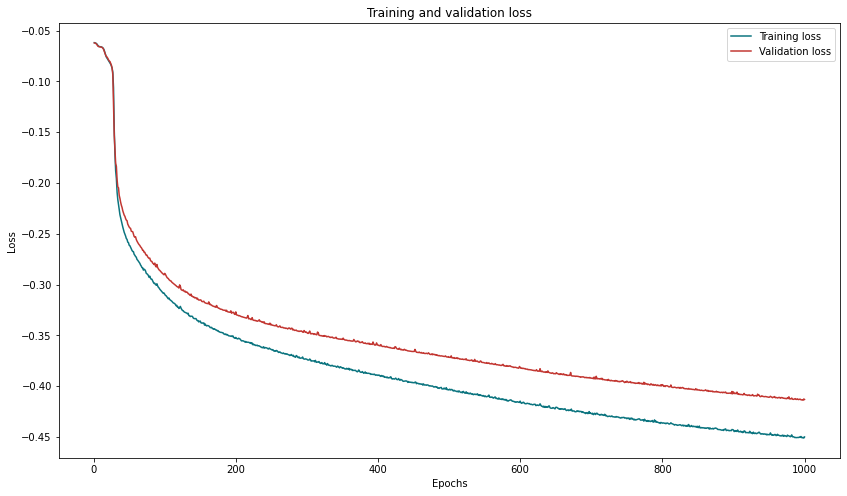

In [ ]:
loss = storico.history['loss']
val_loss = storico.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 8))
plt.plot(epochs, loss, '#0b747f', label='Training loss')
plt.plot(epochs, val_loss, '#c23631', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Save the model for future use
autoencoder.save('/content/drive/MyDrive/Tesi magistrale/modelli_salvati/autoencoder_v1.2_OCT_NonAugmented_1000epoche_LR1e-4_B8_CLAHE.hdf5')

#Predict and Plot

In [ ]:
autoencoder = load_model('/content/drive/MyDrive/Tesi magistrale/modelli_salvati/autoencoder_v1.2_OCTA_Augmented_partial_1000epoche_LR1e-3_B8_CLAHE.hdf5', compile=False)
threshold = 0.5

In [ ]:
y_pred=autoencoder.predict(X_test)
y_pred_thresholded = y_pred > threshold

In [ ]:
#____________ MEAN IOU__________________
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8096574


In [ ]:
#_____________ IOU____________________
intersection = np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print("IoU score is:",iou_score)

IoU score is: 0.6492585730624912


In [ ]:
#_____________ DICE____________________
intersection = np.logical_and(y_test,y_pred_thresholded)
union=np.logical_or(y_test,y_pred_thresholded)
dice_score = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection))
print("Dice score is:", dice_score)

Dice score is: 0.7873338767697168


(1, 304, 304, 1)
(304, 304)


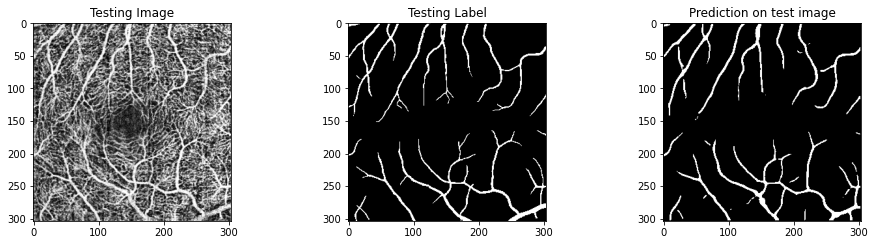

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (autoencoder.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
'''from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
y_pred_values = np.multiply(y_pred_thresholded, 1)
y_test = y_test.astype(int)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred_values)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_values)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_values)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_values)
print('F1 score: %f' % f1)'''

"from sklearn.metrics import accuracy_score\nfrom sklearn.metrics import precision_score\nfrom sklearn.metrics import recall_score\nfrom sklearn.metrics import f1_score\ny_pred_values = np.multiply(y_pred_thresholded, 1)\ny_test = y_test.astype(int)\n\n# accuracy: (tp + tn) / (p + n)\naccuracy = accuracy_score(y_test, y_pred_values)\nprint('Accuracy: %f' % accuracy)\n# precision tp / (tp + fp)\nprecision = precision_score(y_test, y_pred_values)\nprint('Precision: %f' % precision)\n# recall: tp / (tp + fn)\nrecall = recall_score(y_test, y_pred_values)\nprint('Recall: %f' % recall)\n# f1: 2 tp / (2 tp + fp + fn)\nf1 = f1_score(y_test, y_pred_values)\nprint('F1 score: %f' % f1)"

#Overlapping

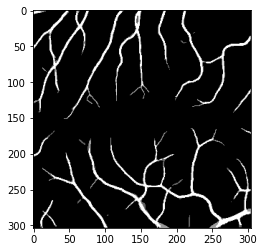

In [ ]:
fig, ax = plt.subplots()
ax.imshow(ground_truth[:,:,0], cmap='gray', alpha=1)
ax.imshow(prediction,cmap='gray', alpha=0.4)
fig.show()

# Plot all test images

In [ ]:
def plot_images(test_images, ground_truth, prediction, i):
  plt.figure()
  i = i+1
  titolo = 'Testing Image '+str(i)
  plt.title(titolo)
  plt.axis("off")
  plt.imshow(test_img[:,:,0], cmap='gray')
  plt.show()

def plot_overlapping(ground_truth, prediction, i):
  fig, ax = plt.subplots()
  ax.imshow(ground_truth[:,:,0], cmap='gray')
  ax.imshow(prediction,cmap='gray', alpha=0.4)
  i = i+1
  titolo = 'Masks Overlapping '+str(i)
  ax.set_title(titolo)
  ax.axis("off")
  fig.show() 

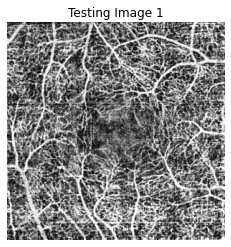

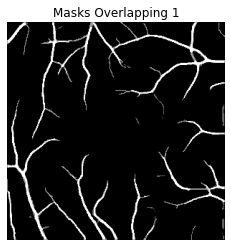

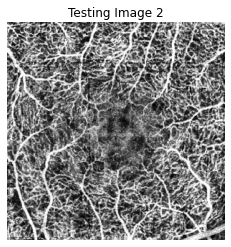

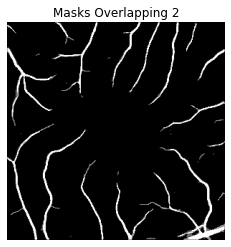

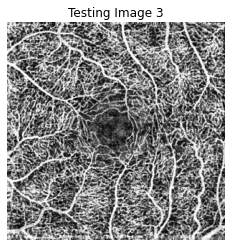

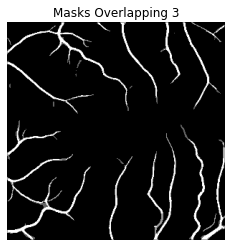

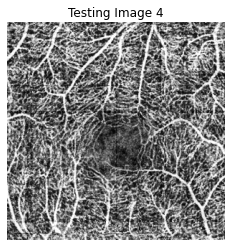

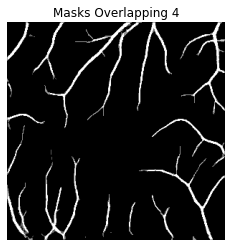

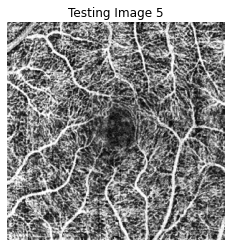

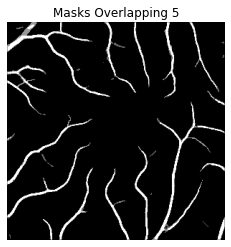

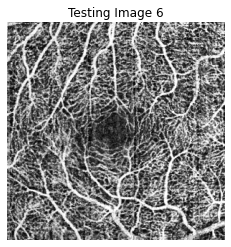

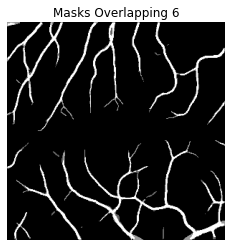

In [ ]:
for i in range(len(X_test)):
  test_img_number = i
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (autoencoder.predict(test_img_input)[0,:,:,0] > threshold).astype(np.uint8)
  
  plot_images(test_img, ground_truth, prediction, i)
  plot_overlapping(ground_truth, prediction, i)